## Create orders
last modified: 1/12/2018

### Import and instantiate

In [1]:
%load_ext autoreload
%autoreload 1
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import linear_model
import json
from datetime import datetime, timedelta
from time import sleep

# Temporary fix until matplotlib version and pandas updates
from pandas.plotting import register_matplotlib_converters
junk = register_matplotlib_converters()

In [3]:
import sys, os
sys.path.append(os.path.join(os.path.dirname('.'), '..', 'lib'))

from tdameritrade import tdameritrade_api
from interactivebrokers import ib_api as IB_API
from strategies import orders

In [4]:
ib_api = IB_API.main(host="192.168.1.2", port=7496)

serverVersion:142 connectionTime:b'20190829 06:27:38 EST'


ERROR -1 2104 Market data farm connection is OK:usfuture
ERROR -1 2104 Market data farm connection is OK:usfarm
ERROR -1 2106 HMDS data farm connection is OK:euhmds
ERROR -1 2106 HMDS data farm connection is OK:fundfarm
ERROR -1 2106 HMDS data farm connection is OK:ushmds


-1
-1
-1
-1
-1


In [5]:
#td_api = tdameritrade_api.TDAmeritradeAPI.create_api_from_account_file(filename="../private_data/information.json")

In [6]:
with open("../private_data/information.json") as file_obj:
    information = json.load(file_obj)

ACCOUNT_IRA = information["IB_IRA"]
ACCOUNT_IND = information["IB_IND"]

In [7]:
with pd.HDFStore("/home/brent/.jupyter/data/data.hdf", mode="r") as hdf_store:
    bars = hdf_store["bars"]
    fundamentals = hdf_store["fundamentals"]
    quotes = hdf_store["quotes"]
    positions = hdf_store["positions"]
    universe = bars.columns.get_level_values(0).unique()

### Function definitions

In [16]:
def volatility_orders(symbols=None, amount=1000, number_brackets=1, 
                      instruction="BUY", bars=None, make_plots=False):
    
    # important to have sorted lists as Pandas will automatically sort slices
    symbols.sort()
    
    if bars is None:
        end_date = datetime.today()
        start_date = end_date - timedelta(days=20)
        data = ib_api.get_price_history(symbols, start_date=start_date, end_date=end_date, bar_size="1 day", rth=False)
    else:
        data = bars.loc[:, (symbols, slice(None))].iloc[-20:].copy()
        
    reg = linear_model.LinearRegression()
    X = np.array([[i] for i in range(0, data.shape[0])])
    P_pred = pd.DataFrame(index=symbols, columns=pd.MultiIndex.from_product([["high", "low"],["P", "P_std"]]))

    for col in P_pred.columns.get_level_values(0).unique():
        P = data.loc[:, (slice(None), col)].values
        reg.fit(X, P)
        P_lin = reg.predict(X)

        temp = reg.coef_ * np.array([15]).T
        temp = temp.T + reg.intercept_
        P_pred.loc[:, (col, "P")] = temp[0]
        P_pred.loc[:, (col, "P_std")] = np.std(P - P_lin, axis=0)

        for i, symbol in enumerate(symbols):
            data.loc[:, (symbol, col+"_lin")] = P_lin[:, i]

    data.sort_index(axis=1, inplace=True)
    
    quantity_factors = 1 + np.arange(0, 10, 0.5)[:number_brackets]
    std_factors = np.arange(0, 5, 0.5)[:number_brackets]
    
    if instruction == "BUY":
        orders = []
        for symbol in symbols:
            quantity = int(amount / P_pred.loc[symbol, ("low", "P")])
            quantities = quantity * quantity_factors
            limits = P_pred.loc[symbol, ("low", "P")] - P_pred.loc[symbol, ("low", "P_std")] * std_factors
            profits = P_pred.loc[symbol, ("high", "P")] - P_pred.loc[symbol, ("high", "P_std")] * std_factors
            stop = 0.95 * P_pred.loc[symbol, ("low", "P")]
            for limit, profit, q in zip(limits, profits, quantities):
                orders.append(
                    {
                        "symbol": symbol,
                        "instruction": "BUY",
                        "price": round(limit, 2),
                        "quantity": int(q),
                        "outside_rth": True,
                        "tif": "DAY",
                        "profit_price": round(profit, 2),
                        "stop_price": round(stop, 2)
                    }
                )
    elif instruction == "SELL":
        orders = []
        for symbol in symbols:
            quantity = int(amount / P_pred.loc[symbol, ("low", "P")])
            quantities = quantity * quantity_factors
            limits = P_pred.loc[symbol, ("high", "P")] + P_pred.loc[symbol, ("high", "P_std")] * std_factors
            profits = P_pred.loc[symbol, ("low", "P")] + P_pred.loc[symbol, ("low", "P_std")] * std_factors
            stop = 1.05 * P_pred.loc[symbol, ("high", "P")]
            for limit, profit, q in zip(limits, profits, quantities):
                orders.append(
                    {
                        "symbol": symbol,
                        "instruction": "SELL",
                        "price": round(limit, 2),
                        "quantity": int(q),
                        "outside_rth": True,
                        "tif": "DAY",
                        "profit_price": round(profit, 2),
                        "stop_price": round(stop, 2)
                    }
                )
                
    if make_plots is True:
        n = len(symbols)
        rows = int(np.ceil(n / 3))
        columns = 3
        fig, ax = plt.subplots(rows, columns, figsize=(20,rows*6))
        for i in range(rows):
            for j in range(columns):
                total = 3*i + j
                if  total + 1 > n:
                    break
                symbol = symbols[3*i + j]
                ax[i][j].plot(data.loc[:, (symbol, "high")], color="blue", marker="o")
                ax[i][j].plot(data.loc[:, (symbol, "high_lin")], color="blue")
                ax[i][j].plot(data.index[-1] + timedelta(days=1), P_pred.loc[symbol, ("high", "P")], marker="s", color="blue", ms=10)
                ax[i][j].plot(data.loc[:, (symbol, "low")], color="green", marker="o")
                ax[i][j].plot(data.loc[:, (symbol, "low_lin")], color="green")
                ax[i][j].plot(data.index[-1] + timedelta(days=1), P_pred.loc[symbol, ("low", "P")], marker="s", color="green", ms=10)
                ax[i][j].set_title(symbol)
    return orders

### Volatility trades

#### BUY

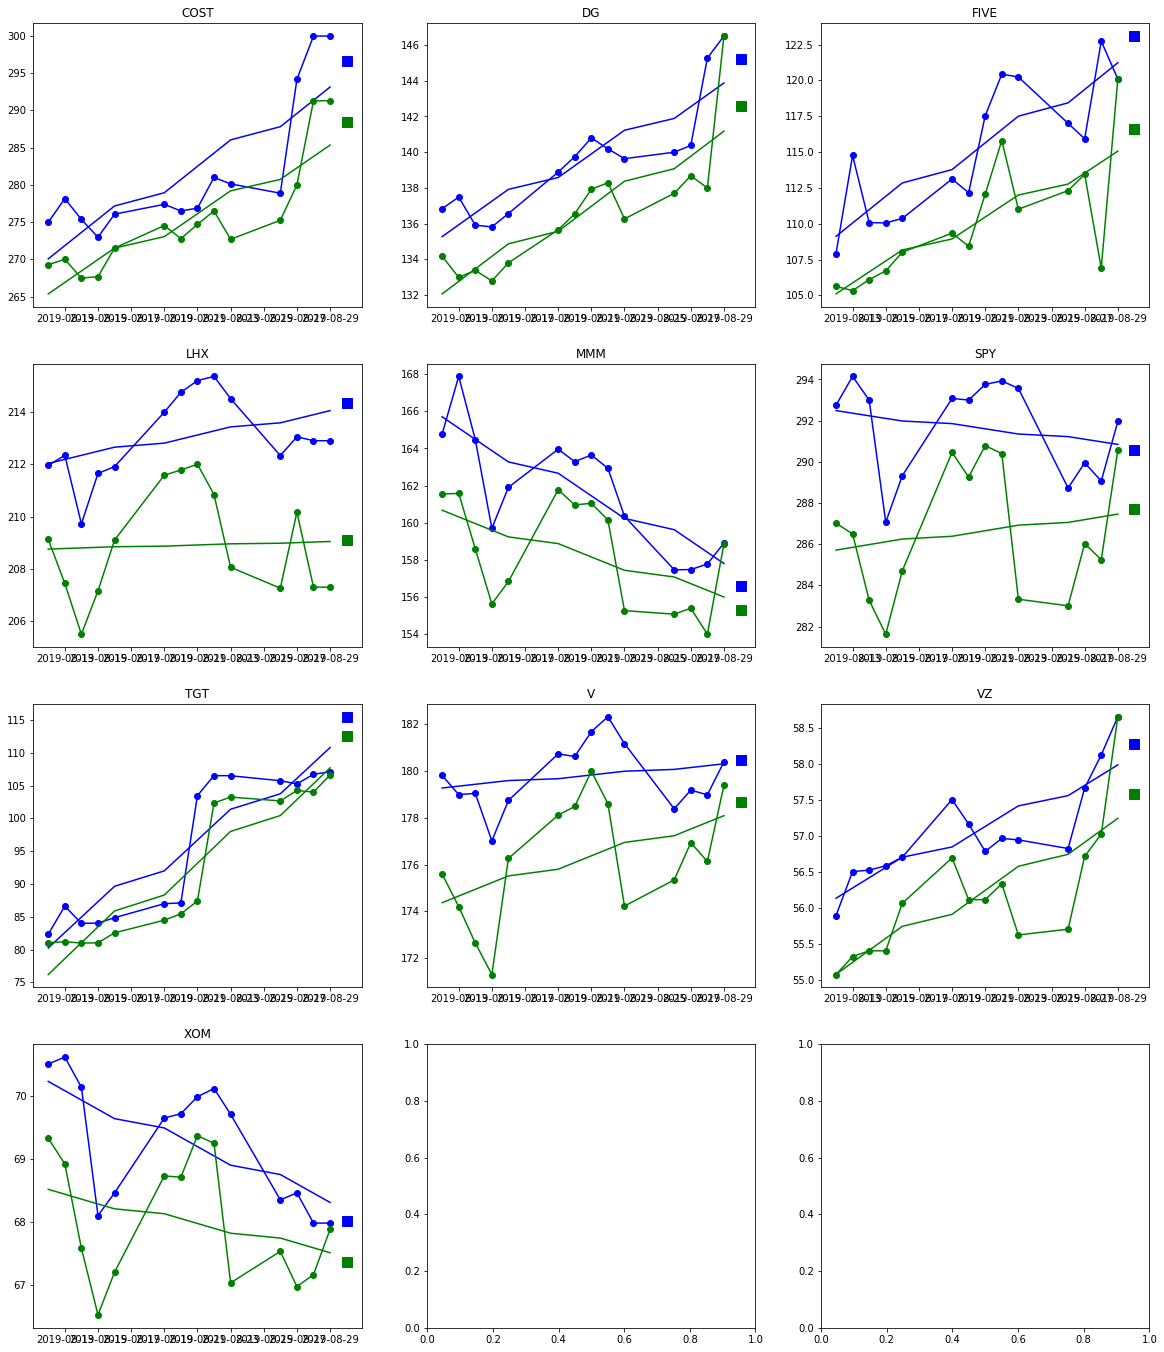

In [17]:
symbols = "SPY, COST, FIVE, XOM, MMM, LHX, TGT, DG, V, VZ".split((", "))
bracket_orders = volatility_orders(symbols=symbols, bars=None, instruction="BUY", make_plots=True)

In [20]:
ib_api.create_bracket_orders(bracket_orders)
ib_api.place_all_orders()

#### SELL

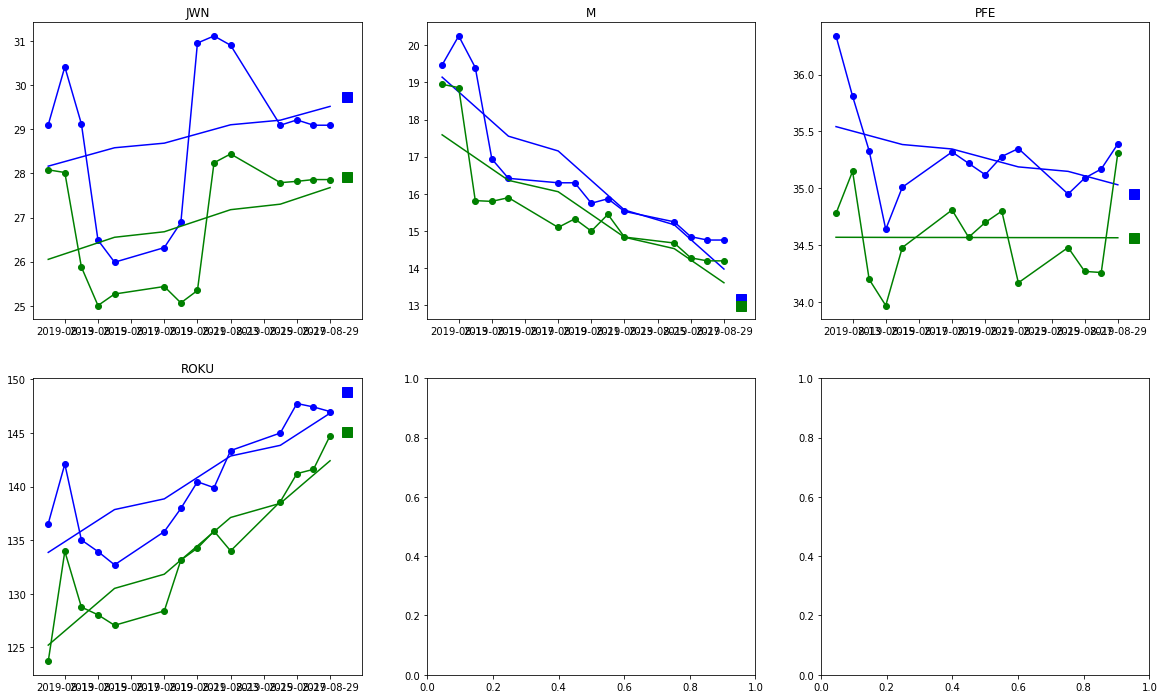

In [21]:
symbols = "ROKU, JWN, M, PFE".split((", "))
bracket_orders = volatility_orders(symbols=symbols, bars=None, instruction="SELL", make_plots=True)

In [22]:
ib_api.create_bracket_orders(bracket_orders)
ib_api.place_all_orders()

ERROR 1975 103 Duplicate order id
ERROR 1976 103 Duplicate order id
ERROR 1977 103 Duplicate order id
ERROR 1978 103 Duplicate order id
ERROR 1979 103 Duplicate order id
ERROR 1980 103 Duplicate order id
ERROR 1981 103 Duplicate order id
ERROR 1982 103 Duplicate order id
ERROR 1983 103 Duplicate order id


1975
1976
1977
1978
1979
1980
1981
1982
1983


ERROR 1973 399 Order Message:
SELL 14 XOM NYSE


1973


ERROR 1967 399 Order Message:
SELL 5 V NYSE


1967


ERROR 1964 399 Order Message:
SELL 8 TGT NYSE


1964


ERROR 1958 399 Order Message:
SELL 6 MMM NYSE


1958


ERROR 1955 399 Order Message:
SELL 4 LHX NYSE


1955


ERROR 1953 399 Order Message:
SELL 8 FIVE NASDAQ.NMS


1953


#### Accumulate

In [20]:
symbols = "LHX, GOOGL, COST, DG, FIVE, JNJ".split(", ")
end_time=datetime.today()
start_time = end_time - timedelta(days=0, hours=5)
temp = ib_api.get_price_history(symbols, start_date=start_time, end_date=end_time, bar_size="10 mins", rth=False)

In [ ]:
ib_api.get_histogram("MMM")

In [10]:
temp = ib_api.get_price_history(["LHX"], start_date=datetime.today()-timedelta(days=2), end_date=datetime.today(), bar_size="1 day", rth=True)

> /home/brent/.jupyter/lib/interactivebrokers/ib_api.py(606)get_price_history()
-> for symbol in symbols:
(Pdb) c


In [10]:
long_bracket = "LHX, GOOGL, MSFT, CVS, JNJ".split(", ")
short_bracket = "".split(", ")
short_stop_limit = "".split(", ")

ERROR -1 2104 Market data farm connection is OK:usopt


-1


ERROR -1 2108 Market data farm connection is inactive but should be available upon demand.usopt
ERROR -1 2108 Market data farm connection is inactive but should be available upon demand.usopt


-1
-1


In [ ]:
with symbol in long_bracket:
    ib_api.create_stop_li

#### Accumulate

In [7]:
symbols = "LHX, GOOGLE, MSFT, JNJ".split(", ")
symbols = ["MSFT", "GOOGL"]
end_time=datetime.today()
start_time = end_time - timedelta(days=0, hours=1)
temp = ib_api.get_price_history(symbols, start_date=start_time, end_date=end_time, bar_size="10 mins", rth=True)

In [10]:
temp = ib_api.get_price_history(["LHX"], start_date=datetime.today()-timedelta(days=2), end_date=datetime.today(), bar_size="1 day", rth=True)

> /home/brent/.jupyter/lib/interactivebrokers/ib_api.py(606)get_price_history()
-> for symbol in symbols:
(Pdb) c


In [10]:
long_bracket = "LHX, GOOGL, MSFT, CVS, JNJ".split(", ")
short_bracket = "".split(", ")
short_stop_limit = "".split(", ")

ERROR -1 2104 Market data farm connection is OK:usopt


-1


ERROR -1 2108 Market data farm connection is inactive but should be available upon demand.usopt
ERROR -1 2108 Market data farm connection is inactive but should be available upon demand.usopt


-1
-1


In [ ]:
with symbol in long_bracket:
    ib_api.create_stop_li

**Before (morning) earnings stop limit orders**

In [16]:
with pd.HDFStore("trades.hdf", mode="r") as hdf_store:
    stop_orders = hdf_store["before_earnings_stop_limit_orders"]
stop_orders

OSError: ``trades.hdf`` does not exist

In [18]:
orders = [order[1].to_dict() for order in stop_orders.iterrows()]
ib_api.create_stop_limit_orders(orders)

In [19]:
ib_api.place_all_orders()

**After (after market close) earnings stop limit orders**

In [41]:
with pd.HDFStore("trades.hdf", mode="r") as hdf_store:
    orders = hdf_store["after_earnings_stop_limit_orders"]
orders

,instruction,limit_price,outside_rth,profit_price,quantity,stop_price,symbol,tif
0,SELL,1598.85,True,1663.45,0,1615.00,AMZN,DAY
1,SELL,86.70,True,90.21,11,87.58,PKI,DAY


In [36]:
orders = [order[1].to_dict() for order in orders.iterrows()]
ib_api.create_stop_limit_orders(orders)
ib_api.place_all_orders()

**Dividend bracket orders**

In [19]:
dividend_buys = list(set(dividends.index) - set(positions.loc[positions.account=="U2728633"]))
dividend_buys = dividends.loc[dividend_buys].sort_values('dividendDate')
dividend_buys.head(5)

NameError: name 'dividends' is not defined

In [70]:
fundamentals.loc[dividend_buys.index, ["dividendYield", "currentRatio", "quickRatio", "peRatio", "pegRatio", "pbRatio", "pcfRatio", "prRatio", "totalDebtToCapital", "totalDebtToEquity"]]

,dividendYield,currentRatio,quickRatio,peRatio,pegRatio,pbRatio,pcfRatio,prRatio,totalDebtToCapital,totalDebtToEquity
PGR,3.85,0.00000,0.00000,14.75519,0.201291,3.51910,15.00132,1.19167,28,40
NSC,2.07,0.71864,0.63875,17.34457,0.517210,2.88168,11.92836,3.92476,42,72
SYF,2.82,0.00000,0.00000,7.95873,0.186162,1.45885,9.60566,1.30690,0,163
MET,3.73,0.00000,0.00000,9.44354,0.054517,0.86901,0.00000,0.65722,24,32
AAL,1.19,0.58099,0.48459,7.57372,1.178699,0.00000,3.72168,0.36447,102,0
AWK,1.92,0.45767,0.43364,29.00241,3.213471,2.87444,15.38306,4.93827,58,143
FE,3.87,0.44759,0.40621,0.00000,0.000000,2.91621,0.00000,1.65421,73,282
AEP,3.45,0.55688,0.45626,19.59284,8.247360,1.98820,9.29618,2.33698,56,131
JBHT,1.01,1.11139,0.00000,24.21829,0.000000,5.39886,12.49470,1.32255,35,54
HP,5.40,2.95770,2.53843,0.00000,0.000000,1.32850,10.68424,2.34973,10,11


In [18]:
limit_percent = np.linspace(-0.2, -3.0, dividends.shape[0])
for i, symbol in enumerate(dividends.drop(["AON", "PNW", "LW", "AWK", "FE", "WEC"], axis=0).sort_values("dividendDate").index):
    if symbol not in positions.loc[ACCOUNT_IRA, "symbol"].values:
        ib_api.quick_bracket(symbol=symbol, instruction="BUY", amount=1000, limit_percent=limit_percent[i], profit_percent=3)

NameError: name 'dividends' is not defined

Sell bracket orders for positions.

In [72]:
position_sells = list(set(positions.loc[positions.account=="U2728633"]) - set(dividends.index))
position_sells

['cost', 'position', 'account', 'secType']

In [76]:
positions.loc[positions.account=="U2728633"]

,cost,position,secType,account
symbol,,,,
FL,56.968824,17.0,STK,U2728633
ABT,69.681429,14.0,STK,U2728633
LOW,94.790000,10.0,STK,U2728633
PNC,0.000000,0.0,STK,U2728633
CL,62.162500,16.0,STK,U2728633
APA,31.722258,31.0,STK,U2728633
CVS,64.016667,15.0,STK,U2728633
PFE,42.035349,43.0,STK,U2728633
F,8.785000,100.0,STK,U2728633


In [77]:
dividends

,beta,bookValuePerShare,currentRatio,divGrowthRate3Year,dividendAmount,dividendDate,dividendPayAmount,dividendPayDate,dividendYield,epsChange,...,revChangeYear,sharesOutstanding,shortIntDayToCover,shortIntToFloat,symbol,totalDebtToCapital,totalDebtToEquity,vol10DayAvg,vol1DayAvg,vol3MonthAvg
PGR,0.71239,12.30146,0.00000,0.0,2.51,2019-02-01 00:00:00.0,1.1247,2018-02-09 00:00:00.0,3.85,0.0,...,0,583,0,0,PGR,28,40,3185093,3,73
NSC,1.37133,9.41002,0.71864,0.0,3.44,2019-02-01 00:00:00.0,0.7200,2018-06-11 00:00:00.0,2.07,0.0,...,0,272,0,0,NSC,42,72,2251574,2,44
SYF,1.21766,23.25555,0.00000,0.0,0.84,2019-02-01 00:00:00.0,0.1500,2018-05-17 00:00:00.0,2.82,0.0,...,0,718,0,0,SYF,0,163,12075533,12,155
MET,1.19604,0.00000,0.00000,0.0,1.68,2019-02-04 00:00:00.0,0.4200,2018-06-13 00:00:00.0,3.73,0.0,...,0,986,0,0,MET,24,32,4970637,4,144
AAL,1.58535,0.00000,0.58099,0.0,0.40,2019-02-05 00:00:00.0,0.1000,2018-05-22 00:00:00.0,1.19,0.0,...,0,460,0,0,AAL,102,0,10167985,10,185
FE,0.23644,0.00000,0.44759,0.0,1.52,2019-02-06 00:00:00.0,0.3600,2018-06-01 00:00:00.0,3.87,0.0,...,0,511,0,0,FE,73,282,4124255,4,97
AWK,0.21511,3.74117,0.45767,0.0,1.82,2019-02-06 00:00:00.0,0.4550,2018-06-01 00:00:00.0,1.92,0.0,...,0,180,0,0,AWK,58,143,908186,0,20
BA,1.23822,0.00000,1.10412,0.0,8.22,2019-02-07 00:00:00.0,1.7100,2018-06-01 00:00:00.0,2.29,0.0,...,0,567,0,0,BA,111,0,3308731,3,86
HP,1.51786,0.00000,2.95770,0.0,2.84,2019-02-07 00:00:00.0,0.7000,2018-06-01 00:00:00.0,5.40,0.0,...,0,109,0,0,HP,10,11,1411886,1,32
AEP,0.11956,3.46157,0.55688,0.0,2.68,2019-02-07 00:00:00.0,0.6200,2018-06-08 00:00:00.0,3.45,0.0,...,0,493,0,0,AEP,56,131,2357536,2,53


In [75]:
positions

,cost,position,secType,account
symbol,,,,
AAPL,151.922394,16.0,STK,U2437884
MMM,194.640000,20.0,STK,U2437884
FL,56.968824,17.0,STK,U2728633
GOOGL,1079.000000,1.0,STK,U2437884
ABT,69.681429,14.0,STK,U2728633
LOW,94.790000,10.0,STK,U2728633
PNC,0.000000,0.0,STK,U2728633
NVDA,136.030000,20.0,STK,U2437884
CL,62.162500,16.0,STK,U2728633


In [73]:
for pos in positions.iterrows():
    if pos[0] not in dividends:
        print(pos[0])

AAPL
MMM
FL
GOOGL
ABT
LOW
PNC
CL
AGG
APA
HAS
CVS
PFE
DWDP
T
CAG
XOM
CLX
F
C
JNJ
M
IP


### Bracket order buys for soon dividends that are not positions

In [50]:
ib_api.get_quotes("TXN")

TXN    95.33
dtype: float64

In [11]:
symbols = list(set(dividends.index) - set(positions.loc[ACCOUNT_IRA]['symbol']))
quotes = td_api.get_quotes(symbols)
quotes = quotes['regularMarketLastPrice']

INFO:tdameritrade.tdameritrade_api:URL: https://api.tdameritrade.com/v1/marketdata/quotes?symbol=PNR%2CAON%2CCL%2CCLX%2CLW%2CPG%2CAPA%2CPFE%2CFL%2CPNW


In [18]:
bracket_orders = []
for symbol in symbols:
    bracket_orders.append(orders.easy_bracket(symbol=symbol, instruction="BUY", amount=1000, limit_percent=-0.2, profit_percent=1.0, quotes=quotes))
ib_api.create_bracket_orders(req_orders=bracket_orders)

In [19]:
ib_api.place_all_orders()

In [14]:
positions

,cost,position,secType,symbol
account,,,,
U2437884,151.922394,16.0,STK,AAPL
U2437884,194.640000,20.0,STK,MMM
U2728633,163.366667,6.0,STK,GD
U2437884,159.867800,-10.0,STK,QQQ
U2728633,94.790000,10.0,STK,LOW
U2437884,140.454307,-15.0,STK,IWM
U2728633,119.635000,8.0,STK,PNC
U2437884,140.820000,10.0,STK,NVDA
U2728633,110.000000,10.0,STK,AGG


ERROR:root:ERROR -1 2108 Market data farm connection is inactive but should be available upon demand.hfarm
ERROR:root:ERROR -1 2108 Market data farm connection is inactive but should be available upon demand.hfarm
ERROR:root:ERROR -1 2108 Market data farm connection is inactive but should be available upon demand.usfarm.nj
ERROR:root:ERROR -1 2108 Market data farm connection is inactive but should be available upon demand.usfarm.nj
ERROR:root:ERROR -1 2108 Market data farm connection is inactive but should be available upon demand.jfarm
ERROR:root:ERROR -1 2108 Market data farm connection is inactive but should be available upon demand.jfarm
ERROR:root:ERROR -1 2108 Market data farm connection is inactive but should be available upon demand.eufarm
ERROR:root:ERROR -1 2108 Market data farm connection is inactive but should be available upon demand.eufarm
ERROR:root:ERROR -1 2108 Market data farm connection is inactive but should be available upon demand.cashfarm
ERROR:root:ERROR -1 2108

### Filter by fundamentals

In [12]:
fundamentals = td_api.get_fundamental(this_week_dividends + next_week_dividends)

INFO:tdameritrade.tdameritrade_api:URL: https://api.tdameritrade.com/v1/instruments?symbol=ABT%2CAPA%2CCAT%2CCOO%2CDGX%2CEOG%2CFCX%2CFL%2CGD%2CMAA%2CORCL%2CPG%2CPKI%2CPNC%2CABBV%2CZTS%2CCL%2CCLX%2CCVS&projection=fundamental


In [14]:
dividend_buys = fundamentals[fundamentals["dividendYield"]>1].sort_values(by="dividendYield")

In [28]:
dividend_buys.index.values

array(['ANTM', 'ORCL', 'FCX', 'ABT', 'GD', 'FL', 'DGX', 'CLX', 'CAT',
       'CL', 'CVS', 'PG', 'PNC', 'APA', 'MAA', 'ABBV'], dtype=object)

In [20]:
end_date = datetime.today()
start_date = end_date - timedelta(days=300)
bars = td_api.get_price_history(symbols=dividend_buys.index.values, start_date=start_date, end_date=end_date)

INFO:tdameritrade.tdameritrade_api:URL: https://api.tdameritrade.com/v1/marketdata/ANTM/pricehistory?periodType=month&frequencyType=daily&frequency=1&endDate=1547435205000&startDate=1521511605000&needExtendedHoursData=True
INFO:tdameritrade.tdameritrade_api:URL: https://api.tdameritrade.com/v1/marketdata/ORCL/pricehistory?periodType=month&frequencyType=daily&frequency=1&endDate=1547435205000&startDate=1521511605000&needExtendedHoursData=True
INFO:tdameritrade.tdameritrade_api:URL: https://api.tdameritrade.com/v1/marketdata/FCX/pricehistory?periodType=month&frequencyType=daily&frequency=1&endDate=1547435205000&startDate=1521511605000&needExtendedHoursData=True
INFO:tdameritrade.tdameritrade_api:URL: https://api.tdameritrade.com/v1/marketdata/ABT/pricehistory?periodType=month&frequencyType=daily&frequency=1&endDate=1547435205000&startDate=1521511605000&needExtendedHoursData=True
INFO:tdameritrade.tdameritrade_api:URL: https://api.tdameritrade.com/v1/marketdata/GD/pricehistory?periodType=

In [ ]:
orders.easy_bracket(symbol="ORCL", instruction="BUY", )

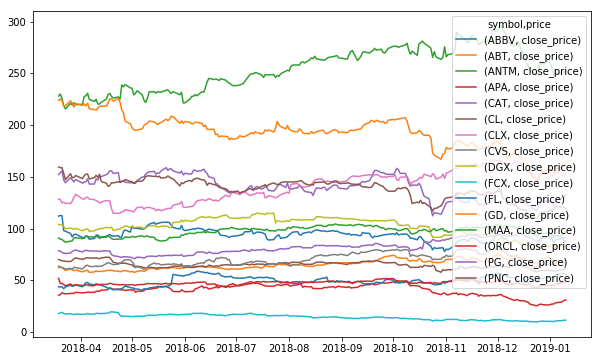

In [27]:
bars.loc[:, (slice(None), 'close_price')].plot(figsize=(10, 6), legend='lower-left')

In [4]:
with pd.HDFStore('bars.hdf', mode='r') as hdf_store:
    bars = hdf_store['index']

In [5]:
hdf_key = 'index'
end_date = datetime.today()
start_date = end_date - timedelta(days=300)
if NEW_START:
    bars = td_api.get_price_history(symbols=tickers, rth=False, start_date=start_date, end_date=end_date)
else:
    new_symbols = list(set(symbols) - set(bars.columns.get_level_values(0).unique()))
    new_bars = app.get_price_history(symbols=new_symbols, rth=False, start_date=start_date, end_date=end_date)
    bars = bars.join(new_bars)
with pd.HDFStore('bars.hdf', mode='w') as hdf_store:
    bars.to_hdf(hdf_store, 'index')

 T


ERROR:root:ERROR 2001 322 Error processing request:-'bI' : cause - Duplicate ticker ID for API historical data query


 SBUX


ERROR:root:ERROR 2001 322 Error processing request:-'bI' : cause - Duplicate ticker ID for API historical data query


 LB


ERROR:root:ERROR 2001 322 Error processing request:-'bI' : cause - Duplicate ticker ID for API historical data query


 GPS
 CL


KeyError: 'CL'

In [10]:
quotes = app.get_quotes(symbols)

ERROR:root:ERROR 2001 162 Historical Market Data Service error message:HMDS query returned no data: DWDP@SMART Trades


KeyboardInterrupt: 

In [64]:
longs = "DWDP, MMM, C, JPM, M"
longs = longs.split(", ")

In [ ]:
shorts =  "NTFLX, WDAY"

**User Defined Orders**

##### Longs

In [23]:
bracket_orders = []
#bracket_orders.append(orders.easy_bracket(symbol="M", instruction="BUY", amount=1000, percent=-1, bars=bars, quotes=quotes))
bracket_orders.append(orders.easy_bracket(symbol="ROKU", instruction="BUY", amount=1000, percent=-.1, bars=bars, quotes=quotes))
bracket_orders.append(orders.easy_bracket(symbol="NFLX", instruction="BUY", amount=1000, percent=-.2, bars=bars, quotes=quotes))

NameError: name 'bars' is not defined

In [63]:
app.create_bracket_orders(bracket_orders)
app.place_all_orders()

**Strategies**

##### Index Volatility Bracket Orders

In [6]:
bracket_orders = []
for symbol in symbols:
    bracket_orders = bracket_orders + strategies.easy_volatility(symbol=symbol, bars=bars, quotes=quotes)

In [8]:
app.create_bracket_orders(bracket_orders)
app.place_all_orders()

**Pegged Orders**

In [4]:
pegged_params = [
    {'symbol': "AMAT", 'instruction': "BUY", 'amount': 1000, 'ref_symbol': "QQQ"},
    {'symbol': "NVDA", 'instruction': "BUY", 'amount': 1000, 'ref_symbol': "QQQ"},
    {'symbol': "MU", 'instruction': "BUY", 'amount': 1000, 'ref_symbol': "QQQ"},
    {'symbol': "AMZN", 'instruction': "BUY", 'amount': 2000, 'ref_symbol': "QQQ"},
    {'symbol': "NFLX", 'instruction': "BUY", 'amount': 1000, 'ref_symbol': "QQQ"},
    {'symbol': "GOOG", 'instruction': "BUY", 'amount': 2000, 'ref_symbol': "QQQ"},
    {'symbol': "FB", 'instruction': "BUY", 'amount': 1000, 'ref_symbol': "QQQ"},
    {'symbol': "WDAY", 'instruction': "BUY", 'amount': 1000, 'ref_symbol': "QQQ"},
    {'symbol': "AMD", 'instruction': "BUY", 'amount': 1000, 'ref_symbol': "QQQ"},
    {'symbol': "INTC", 'instruction': "BUY", 'amount': 1000, 'ref_symbol': "QQQ"},
    {'symbol': "MSFT", 'instruction': "BUY", 'amount': 1000, 'ref_symbol': "QQQ"},
    {'symbol': "AMAT", 'instruction': "SELL", 'amount': 1000, 'ref_symbol': "QQQ"},
    {'symbol': "MU", 'instruction': "SELL", 'amount': 1000, 'ref_symbol': "QQQ"},
    {'symbol': "AMZN", 'instruction': "SELL", 'amount': 2000, 'ref_symbol': "QQQ"},
    {'symbol': "NFLX", 'instruction': "SELL", 'amount': 1000, 'ref_symbol': "QQQ"},
    {'symbol': "GOOG", 'instruction': "SELL", 'amount': 2000, 'ref_symbol': "QQQ"},
    {'symbol': "FB", 'instruction': "SELL", 'amount': 1000, 'ref_symbol': "QQQ"},
    {'symbol': "WDAY", 'instruction': "SELL", 'amount': 1000, 'ref_symbol': "QQQ"},
    {'symbol': "AMD", 'instruction': "SELL", 'amount': 1000, 'ref_symbol': "QQQ"},
    {'symbol': "INTC", 'instruction': "SELL", 'amount': 1000, 'ref_symbol': "QQQ"},
    {'symbol': "MSFT", 'instruction': "SELL", 'amount': 1000, 'ref_symbol': "QQQ"},
    {'symbol': "NVDA", 'instruction': "SELL", 'amount': 1000, 'ref_symbol': "QQQ"},
    {'symbol': "DWDP", 'instruction': "BUY", 'amount': 1000, 'ref_symbol': "SPY"},
    {'symbol': "MMM", 'instruction': "BUY", 'amount': 1000, 'ref_symbol': "SPY"},
    {'symbol': "C", 'instruction': "BUY", 'amount': 1000, 'ref_symbol': "SPY"},
    {'symbol': "JPM", 'instruction': "BUY", 'amount': 1000, 'ref_symbol': "SPY"},
    {'symbol': "CAT", 'instruction': "BUY", 'amount': 1000, 'ref_symbol': "SPY"},
    {'symbol': "BA", 'instruction': "BUY", 'amount': 1000, 'ref_symbol': "SPY"},
    {'symbol': "BAC", 'instruction': "BUY", 'amount': 1000, 'ref_symbol': "SPY"},
    {'symbol': "PFE", 'instruction': "BUY", 'amount': 1000, 'ref_symbol': "SPY"},
    {'symbol': "DWDP", 'instruction': "SELL", 'amount': 1000, 'ref_symbol': "SPY"},
    {'symbol': "MMM", 'instruction': "SELL", 'amount': 1000, 'ref_symbol': "SPY"},
    {'symbol': "C", 'instruction': "SELL", 'amount': 1000, 'ref_symbol': "SPY"},
    {'symbol': "JPM", 'instruction': "SELL", 'amount': 1000, 'ref_symbol': "SPY"},
    {'symbol': "CAT", 'instruction': "SELL", 'amount': 1000, 'ref_symbol': "SPY"},
    {'symbol': "BA", 'instruction': "SELL", 'amount': 1000, 'ref_symbol': "SPY"},
    {'symbol': "BAC", 'instruction': "SELL", 'amount': 1000, 'ref_symbol': "SPY"},
    {'symbol': "PFE", 'instruction': "SELL", 'amount': 1000, 'ref_symbol': "SPY"},
]

In [5]:
symbols = list(set([o['symbol'] for o in pegged_params] + [o['ref_symbol'] for o in pegged_params]))
quotes = app.get_quotes(symbols)

pegged_orders = list()
for order in pegged_params:
    print(order['symbol'])
    pegged_orders.append(orders.pegged_order(symbol=order['symbol'], instruction=order['instruction'], amount=order['amount'],
                                             ref_symbol=order['ref_symbol'], quotes=quotes))
# print(pegged_orders)
app.create_pegged_orders(pegged_orders)
# print(app.get_saved_orders())
app.place_all_orders()

AMAT
NVDA
MU
AMZN
NFLX
GOOG
FB
WDAY
AMD
INTC
MSFT
AMAT
MU
AMZN
NFLX
GOOG
FB
WDAY
AMD
INTC
MSFT
NVDA
DWDP
MMM
C
JPM
CAT
BA
BAC
PFE
DWDP
MMM
C
JPM
CAT
BA
BAC
PFE


ERROR:root:ERROR 507 103 Duplicate order id
ERROR:root:ERROR 508 103 Duplicate order id
ERROR:root:ERROR 509 103 Duplicate order id
ERROR:root:ERROR 510 103 Duplicate order id
ERROR:root:ERROR 511 103 Duplicate order id


In [17]:
prices = bars['NVDA'].iloc[-50:]
low = prices['open_price'] - prices['low']
high = prices['high'] - prices['open_price']

In [29]:
low.quantile(0.4)

2.815999999999997

In [30]:
low.quantile(0.6)

5.391999999999996

In [24]:
a = low > low.quantile(0.4)
b = low < low.quantile(0.6)

In [28]:
high[(low>low.quantile(0.4)) & (low<low.quantile(0.6))]

20181101    6.34
20181107    3.41
20181109    5.32
20181128    3.95
20181129    1.87
20181206    5.37
20181212    2.80
20181220    3.80
20181231    0.71
20190103    3.66
dtype: float64

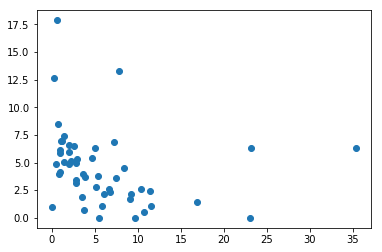

In [18]:
plt.scatter(low, high)

In [12]:
prices

price,close_price,high,low,open_price,volume
20181029,45.49,46.75,44.44,45.77,324594.0
20181030,47.99,48.00,45.07,45.49,388869.0
20181031,47.00,48.56,46.82,47.74,298621.0
20181101,48.05,48.47,46.83,47.01,254296.0
20181102,47.19,48.73,46.75,48.66,286576.0
20181105,48.05,48.25,46.92,47.16,219173.0
20181106,47.35,47.92,47.03,47.80,226457.0
20181107,48.82,48.84,47.48,47.62,285024.0
20181108,49.00,49.29,48.33,48.66,245440.0
20181109,47.93,49.03,47.87,48.75,202056.0


### Pegged orders

In [11]:
quotes = ib_api.get_quotes(["AMZN", "MSFT", "INTC", "NVDA"])

In [13]:
quotes["AMZN"]

1867.0

In [ ]:
orders = [
    {
        'symbol': 'AMZN',
        'instruction': 'BUY',
        'quantity': 1,
        'starting_price': quotes["AMZN"],
        'outside_rth': True,
        'tif': 'DAY',
        
    }
]


In [ ]:
ib_api.create_pegged_orders()